In [49]:
import os, sys
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.set_random_seed(0)

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import itertools
import time
import itertools
from IPython.display import display, clear_output
import glob
import tqdm

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.initializers import glorot_uniform
from keras import optimizers

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
VERSION = '02'

try:
    import google.colab
    from google.colab import drive

    drive.mount('/content/gdrive', force_remount=True)
    root_path = 'gdrive/My Drive/Colab Notebooks/PNXS/'
    print('Working on google colab')
except:
    root_path = '../'
    print('Working locally')

directory= f'{root_path}models/{VERSION}'
if not os.path.exists(directory):
    os.makedirs(directory)    
    
# sys.path.append(f'{root_path}/rsc/{VERSION}')

# from load_data import load_data
# from pre_process_data import pre_process_data
# from create_model import create_model, print_version
# from helper import play_bell, LossHistory, add_grid_and_save
# from train_model import train_model
# from run_training import run_training
# from parameter_space import Parameter_space


Working locally


In [52]:
# mask_files

with_mask = []
for i, f in enumerate(tqdm.tqdm_notebook(mask_files)):
    m = np.sum(img_to_array(load_img(f, color_mode='grayscale'))/255.)
    with_mask.append(m>1)
np.mean(with_mask)

0.2226705451815708

In [71]:
len(mask_files)/32-250

83.0

In [172]:
xray_path = f'{root_path}data/train/*'
mask_path = f'{root_path}data/masks/*'
xray_files = sorted(glob.glob(xray_path))[:-19]
mask_files = sorted(glob.glob(mask_path))[:-19]


import random
random.seed(2)

c = list(zip(xray_files, mask_files))
random.shuffle(c)
xray_files, mask_files = zip(*c)

batch_size = 32

train_len = 250 * batch_size
dev_len = 40 * batch_size
test_len = 40 * batch_size

X_train_files = xray_files[:train_len]
y_train_files = mask_files[:train_len]

X_dev_files = xray_files[train_len:train_len+dev_len]
y_dev_files = mask_files[train_len:train_len+dev_len]

X_test_files = xray_files[train_len+dev_len:train_len+dev_len+test_len]
y_test_files = mask_files[train_len+dev_len:train_len+dev_len+test_len]

print(f'Train:{len(X_train_files)}, dev:{len(X_dev_files)}, test:{len(X_test_files)}')

Train:8000, dev:1280, test:1280


In [173]:
with_mask = []
for i, f in enumerate(y_train_files):
    m = np.sum(img_to_array(load_img(f, color_mode='grayscale')))
    with_mask.append(m>1)
train_positive = np.mean(with_mask)

with_mask = []
for i, f in enumerate(y_dev_files):
    m = np.sum(img_to_array(load_img(f, color_mode='grayscale')))
    with_mask.append(m>1)
dev_positive = np.mean(with_mask)

with_mask = []
for i, f in enumerate(y_test_files):
    m = np.sum(img_to_array(load_img(f, color_mode='grayscale')))
    with_mask.append(m>1)
test_positive = np.mean(with_mask)

print('Images with mask:')
print(f'Train:{train_positive}, dev:{dev_positive}, test:{test_positive}')

Images with mask:
Train:0.22075, dev:0.22734375, test:0.2296875


In [174]:
import h5py
data_filename = f'{root_path}data/data.h5'
with h5py.File(data_filename, "w") as out:
    
    data_type = 'uint8'
    
    out.create_dataset("X_train",(len(X_train_files),256,256,1),dtype=data_type)
    out.create_dataset("Y_train",(len(X_train_files),256,256,1),dtype=data_type)      
    out.create_dataset("X_dev",(len(X_dev_files),256,256,1),dtype=data_type)
    out.create_dataset("Y_dev",(len(X_dev_files),256,256,1),dtype=data_type)      
    out.create_dataset("X_test",(len(X_test_files),256,256,1),dtype=data_type)
    out.create_dataset("Y_test",(len(X_test_files),256,256,1),dtype=data_type)
    
    for index in range(len(y_train_files)):
        out['X_train'][index, :, :, :] = img_to_array(load_img(X_train_files[index], color_mode='grayscale')).astype(data_type)
        out['Y_train'][index, :, :, :] = img_to_array(load_img(y_train_files[index], color_mode='grayscale')).astype(data_type)
        
    for index in range(len(y_dev_files)):
        out['X_dev'][index, :, :, :] = img_to_array(load_img(X_dev_files[index], color_mode='grayscale')).astype(data_type)
        out['Y_dev'][index, :, :, :] = img_to_array(load_img(y_dev_files[index], color_mode='grayscale')).astype(data_type)
        
    for index in range(len(y_test_files)):
        out['X_test'][index, :, :, :] = img_to_array(load_img(X_test_files[index], color_mode='grayscale')).astype(data_type)
        out['Y_test'][index, :, :, :] = img_to_array(load_img(y_test_files[index], color_mode='grayscale')).astype(data_type)


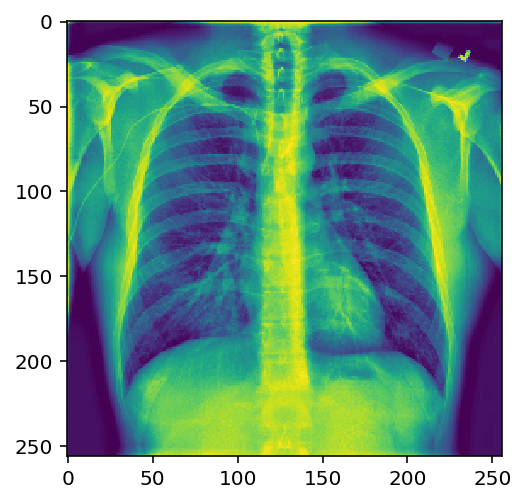

In [175]:
with h5py.File(data_filename, 'r') as f:
    a = f['X_train'][()]
    
plt.imshow(a[7,:,:,0]/255)

In [177]:
def create_data_generator(X, y, batch_size):    
    number_of_samples = X.shape[0]
    print(f'Creating generator from {number_of_samples} samples')
    
    index = 0
    while True:
        data_X = np.zeros([batch_size, 256, 256, 1])
        data_y = np.zeros([batch_size, 256, 256, 1])
        
        for i in range(batch_size):
            data_X[i, ...] = X[index % number_of_samples,...]/255.
            data_y[i, ...] = y[index % number_of_samples,...]/255.
            index = index + 1
            
        data_X = data_X * np.ones([batch_size, 256, 256, 3])
        yield data_X, data_y

In [194]:
with h5py.File(data_filename, 'r') as f:
    train_generator = create_data_generator(f['X_train'][()], f['Y_train'][()], 32)
    
with h5py.File(data_filename, 'r') as f:
    dev_generator = create_data_generator(f['X_dev'][()], f['Y_dev'][()], 32)

In [13]:
# a = next(train_generator)
# a[0][0].shape

In [14]:
# for a in range(2):
#     i, o = next(train_generator)
#     plt.imshow(i[0][:,:,2].reshape(256, 256), cmap='bone')
#     plt.imshow(o[0][:,:,0].reshape(256, 256), alpha=0.5)
#     plt.show()

In [195]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (256, 256, 3))

conv_base.trainable=False

In [16]:
# conv_base.summary()

In [196]:
from keras import models


doctor_model = models.Sequential()
doctor_model.add(conv_base)

doctor_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
doctor_model.add(UpSampling2D((16,16)))
# doctor_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# doctor_model.add(UpSampling2D((4,4)))
doctor_model.add(Conv2D(1, (3, 3), activation='relu', padding='same'))
doctor_model.add(UpSampling2D((2,2)))

doctor_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         589952    
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 1)       1153      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 256, 256, 1)       0         
Total params: 15,305,793
Trainable params: 591,105
Non-trainable params: 14,714,688
_________________________________________________________________


In [197]:
doctor_model.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=2e-5))
outs = []

In [198]:
out = doctor_model.fit_generator(train_generator,
                                 steps_per_epoch = 250,
                                 epochs=1,
                                 validation_data = dev_generator,
                                 validation_steps = 40)

outs.append(out)

Epoch 1/1
Creating generator from 1280 samplesCreating generator from 8000 samples

  1/250 [..............................] - ETA: 1:06:25 - loss: 0.1006

KeyboardInterrupt: 

In [20]:
# xray_path = f'{root_path}data/train/*'
# mask_path = f'{root_path}data/masks/*'
# xray_files = sorted(glob.glob(xray_path))[-19::-1]
# mask_files = sorted(glob.glob(mask_path))[-19::-1]

# import random
# random.seed(42)


# c = list(zip(xray_files, mask_files))
# random.shuffle(c)
# xray_files, mask_files = zip(*c)


# X_train_files = xray_files[:32*250]
# y_train_files = mask_files[:32*250]

# X_test_files = xray_files[32*250:32*(80+250)]
# y_test_files = mask_files[32*250:32*(80+250)]



# train_generator = create_train_generator(train_files=X_train_files, target_files=y_train_files, batch_size=32)
# test_generator = create_train_generator(train_files=X_test_files, target_files=y_test_files, batch_size=32)


doctor_model.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=2e-5))
outs = []

In [22]:
out = doctor_model.fit_generator(train_generator,
                                 steps_per_epoch = 250,
                                 epochs=1,
                                 validation_data = test_generator,
                                 validation_steps = 80)

outs.append(out)

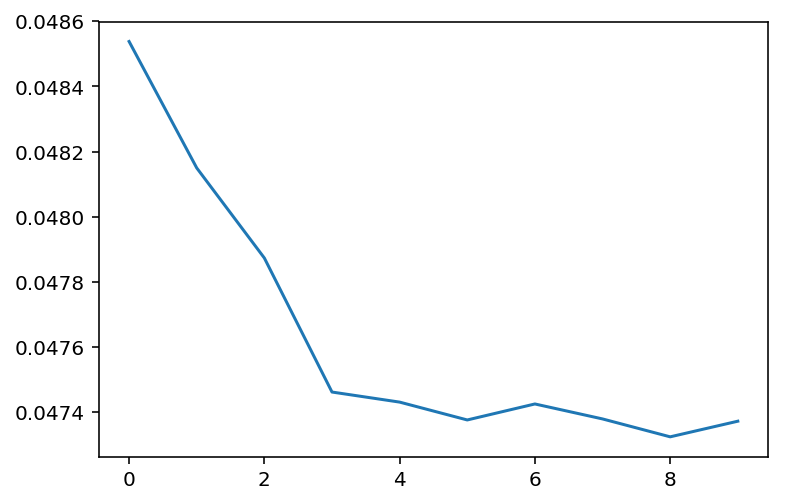

In [157]:


losses = []

for out in outs:
    for loss in out.history['loss']:
        losses.append(loss)
        
plt.plot(losses)

In [ ]:
a, b = next(train_generator)


In [ ]:
img = a[0][:,:,:]
y = doctor_model.predict(a);
# img.shape

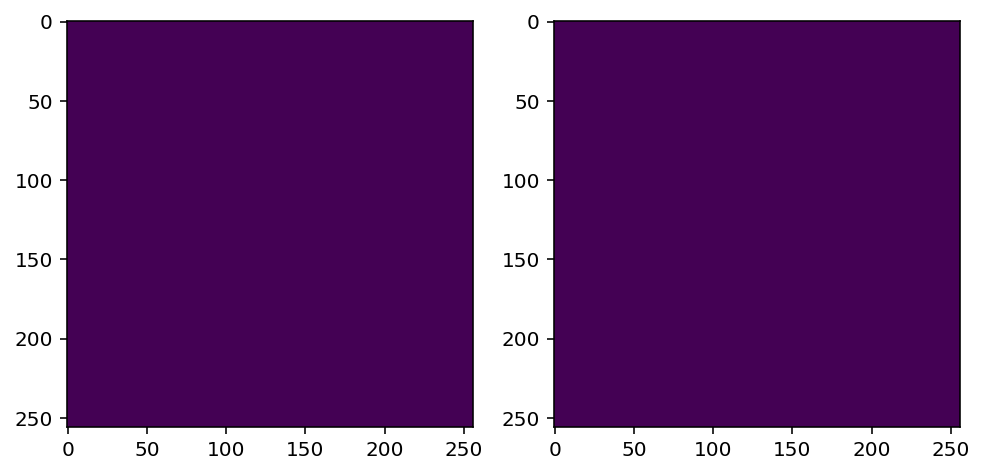

In [179]:
i=6

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(y[i, :, :, 0])
ax2.imshow(b[i, :, :, 0])



In [137]:
%%time
conv_base.predict(a[0])
pass

ValueError: ignored

In [24]:
xray_path = f'{root_path}data/train/*'
mask_path = f'{root_path}data/masks/*'
xray_files = sorted(glob.glob(xray_path))[-19::-1]
mask_files = sorted(glob.glob(mask_path))[-19::-1]
len(mask_files)

10657

In [26]:
import tqdm
import time



def create_train_generator_test(train_files, target_files, batch_size):
    data_len = len(train_files)
    assert(len(target_files) == data_len), 'train-target data number mismatch'
    
    print(f'Creating generator from {data_len} samples')
    
    index = 0
    while True:
        data_train = np.zeros([batch_size, 256, 256, 1])
        data_target = np.zeros([batch_size, 256, 256, 1])

        for i in range(batch_size):
            t0 = time.time()
            img_train = img_to_array(load_img(train_files[index%data_len], color_mode='grayscale'))/255.
            data_train[i, ...] = img_train
          
            img_target = img_to_array(load_img(target_files[index%data_len], color_mode='grayscale'))/255.
            data_target[i, ...] = img_target
            
            if (time.time()-t0)>0.01:
                print(f'{index} - {time.time()-t0} - {train_files[index%data_len]}')
            
            index = index +1
            
        data_train = data_train * np.ones([batch_size, 256, 256, 3])
        data_target = data_target
        yield data_train, data_target
        
        

random.seed(16)
xray_path = f'{root_path}data/train/*'
mask_path = f'{root_path}data/masks/*'
xray_files = sorted(glob.glob(xray_path))[-19::-1]
mask_files = sorted(glob.glob(mask_path))[-19::-1]

c = list(zip(xray_files, mask_files))
random.shuffle(c)
xray_files, mask_files = zip(*c)


X_train_files = xray_files[:32*250]
y_train_files = mask_files[:32*250]

X_test_files = xray_files[32*250:32*(80+250)]
y_test_files = mask_files[32*250:32*(80+250)]
        
train_generator = create_train_generator_test(train_files=X_train_files, target_files=y_train_files, batch_size=32)


In [29]:
# %%time


# for i in tqdm.tqdm(range(333)):
#     a, b = next(train_generator)
#     pass

In [240]:
%%time 
a, b = next(train_generator)

StopIteration: ignored